In [14]:
import multiprocessing as mp
import numpy as np 
from scipy.special import gammaincinv, gamma

from astropy.modeling import models 
from astropy.table import Table
from astropy.modeling import models, fitting
from astropy.utils.console import ProgressBar

from petrofit.models import sersic_enclosed, sersic_enclosed_inv, petrosian_profile, sersic_enclosed, make_grid, PSFModel
from petrofit.petrosian import Petrosian, PetrosianCorrection, calculate_petrosian,discrete_petrosian_r
from petrofit.fitting import model_to_image, fit_model
from petrofit.photometry import calculate_photometic_density,  make_radius_list
from petrofit.petrosian import Petrosian
from petrofit.utils import closest_value_index, get_interpolated_values
from scipy.interpolate import interp1d
from petrofit.petrosian import fraction_flux_to_r

%matplotlib inline

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'
#plt.rcParams.update({'font.size': 17})


import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def savefig(filename):
    plt.savefig("plots/"+filename, dpi=70, bbox_inches = 'tight', pad_inches = 0.1)

In [6]:
run = False 

r_eff_list = [50]#np.arange(5, 100 + 5, 5)
delta = 0.5#0.1
n_list = np.arange(delta, 12 + delta, delta)

rows = []
if run:
    with ProgressBar(len(r_eff_list) * len(n_list), ipython_widget=True) as bar:
        for n_idx, n in enumerate(n_list):

            for r_eff_idx, r_eff in enumerate(r_eff_list):
                bar.update()

                b_n = gammaincinv(2. * n, 0.5)
                amplitude=1 #/np.exp(b_n)

                total_flux = sersic_enclosed(np.inf, amplitude, r_eff, n)
                enclosed_99 = total_flux*.99

                r_99 = sersic_enclosed_inv(enclosed_99, amplitude, r_eff, n)
                r_20 = sersic_enclosed_inv(enclosed_99*0.2, amplitude, r_eff, n)
                r_80 = sersic_enclosed_inv(enclosed_99*0.8, amplitude, r_eff, n)

#                 oversample = 200
#                 max_pix=int(r_99*3)*oversample

#                 r_list = make_radius_list(
#                             max_pix=max_pix, # Max pixel to go up to
#                             n=max_pix,# the number of radii to produce
#                 )
#                 r_list /=oversample
                
                oversample = 1000
                max_pix=int(r_80)*oversample

                r_list = make_radius_list(
                            max_pix=max_pix, # Max pixel to go up to
                            n=max_pix,# the number of radii to produce
                )
                r_list /=oversample
                
                delta = ((2*r_99)-r_80)
                if delta > 1000:
                    delta /= 1000
                else:
                    delta = 1
                    
                r_list = list(r_list) + list(np.arange(r_80+delta, (2*r_99)+delta, delta))
                r_list = np.array(r_list)

                flux_arr = sersic_enclosed(r_list, amplitude, r_eff, n)
                area_arr = np.pi*(r_list**2)

                p = Petrosian(r_list, area_arr, flux_arr)

                #print(total_flux)
                e = r_99 / discrete_petrosian_r(r_list, area_arr, flux_arr, eta=0.2)
                p_corr = Petrosian(r_list, area_arr, flux_arr, epsilon=e)

                rows.append([
                    n, r_eff, amplitude, total_flux, r_99, r_20, r_80, 5 *np.log10(r_80 / r_20),
                    p_corr.eta, p_corr.epsilon, p_corr.r_petrosian, p_corr.r_half_light, p_corr.r_total_flux, p_corr.total_flux, *p_corr.concentration_index(),
                    p.eta, p.epsilon, p.r_petrosian, p.r_half_light, p.r_total_flux, p.total_flux, *p.concentration_index()
                ])

                assert not np.any(np.isnan(np.array(rows[-1]))), "{}".format(n)

    names = [
        "sersic_n", "sersic_r_eff", "sersic_amplitude", "sersic_total_flux_99", "sersic_r_99", "sersic_r_20", "sersic_r_80", "sersic_c2080",
        "corr_eta", "corr_epsilon", "corr_r_petrosian", "corr_r_half_light", "corr_r_total_flux", "corr_total_flux", "corr_r_20", "corr_r_80", "corr_c2080",
        'uncorr_eta', 'uncorr_epsilon', 'uncorr_r_petrosian', 'uncorr_r_half_light', 'uncorr_r_total_flux', 'uncorr_total_flux', 'uncorr_r_20', 'uncorr_r_80', 'uncorr_c2080'
    ]

    t = Table(rows=rows, names=names)

    plt.show()
    print("done")
else:
    t = Table.read('pure_grid.csv')


In [7]:
# t = Table(rows=rows, names=names)

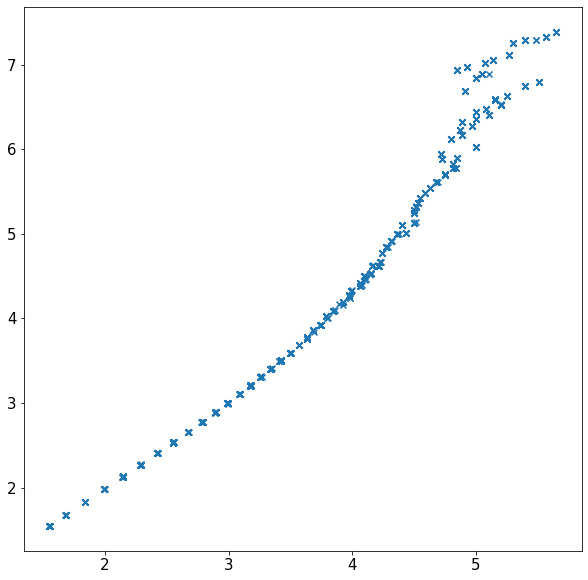

In [8]:
plt.scatter(t['uncorr_c2080'], t['corr_c2080'], marker='x')

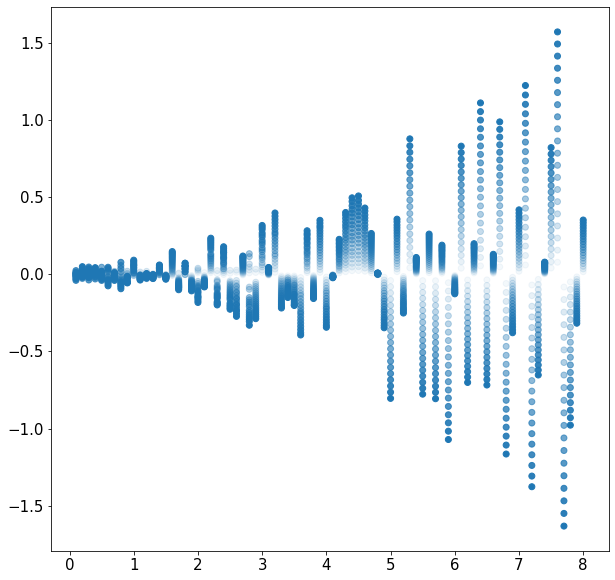

In [9]:
plt.scatter(t['sersic_n'], t['corr_r_20']-t['sersic_r_20'], label='Uncorrected', alpha=t['sersic_r_eff']/t['sersic_r_eff'].max())


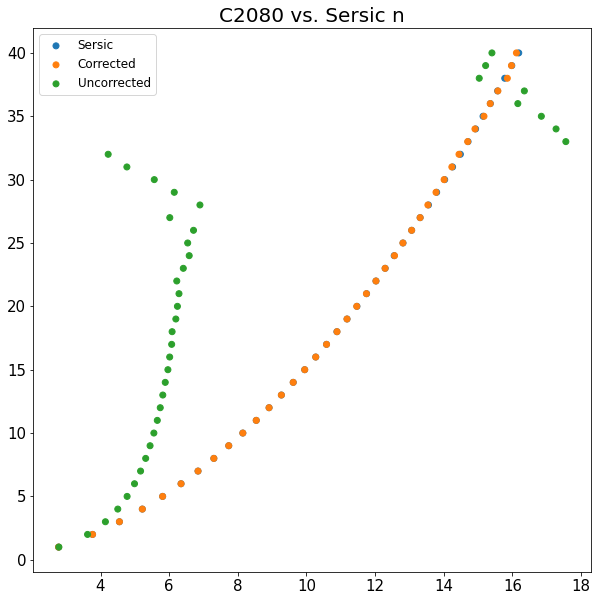

In [128]:
plt.scatter(t['sersic_c2080'], t['sersic_n'], label='Sersic', alpha=t['sersic_r_eff']/t['sersic_r_eff'].max())
plt.scatter(t['corr_c2080'], t['sersic_n'], label='Corrected', alpha=t['sersic_r_eff']/t['sersic_r_eff'].max())
plt.scatter(t['uncorr_c2080'], t['sersic_n'], label='Uncorrected', alpha=t['sersic_r_eff']/t['sersic_r_eff'].max())

#plt.plot(t['sersic_c2080'], 10.0**(-1.5) * np.array(t['sersic_c2080'])**3.5, label='Uncorrected')

plt.title("C2080 vs. Sersic n")
plt.legend()

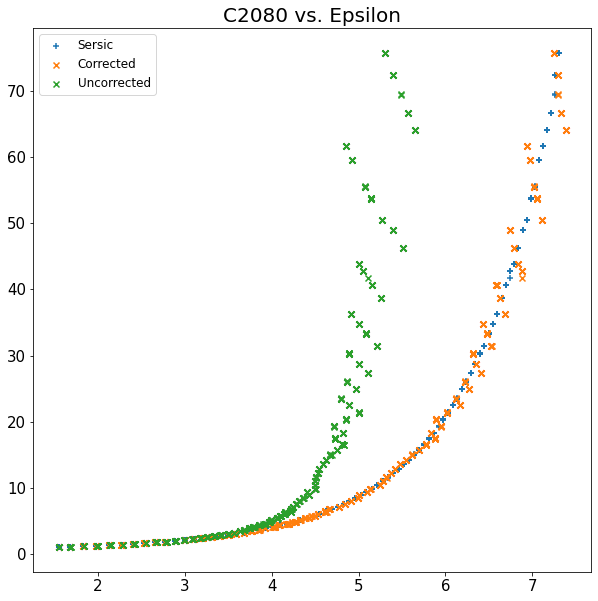

In [12]:
plt.scatter(t['sersic_c2080'], t['corr_epsilon'], label='Sersic', marker='+')
plt.scatter(t['corr_c2080'], t['corr_epsilon'], label='Corrected', marker='x')
plt.scatter(t['uncorr_c2080'], t['corr_epsilon'], label='Uncorrected', marker='x')


plt.title("C2080 vs. Epsilon")
plt.legend()

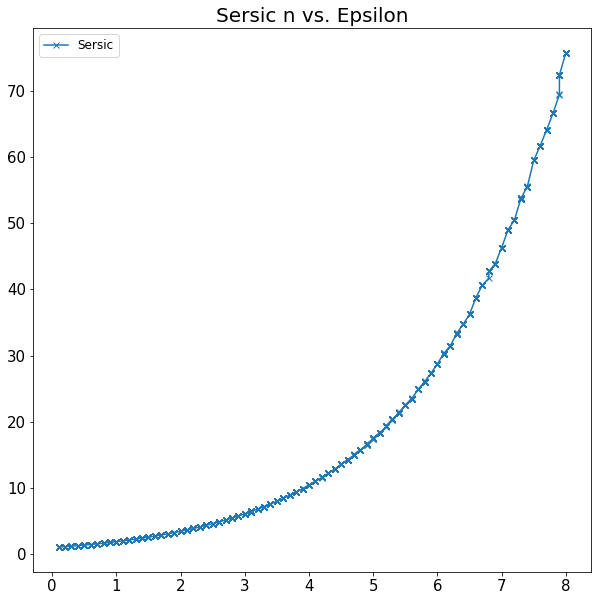

In [13]:
plt.plot(t['sersic_n'], t['corr_epsilon'], label='Sersic', marker='x')
#plt.plot(t['sersic_n'], t['uncorr_epsilon'], label='Sersic', marker='o')

ft = t[t['sersic_n'] > 17]#13.5]

#ft = ft[ft['sersic_n']  < 15.5]

#plt.plot(ft['sersic_n'], ft['corr_epsilon'], label='Sersic', marker='x')

plt.title("Sersic n vs. Epsilon")
plt.legend()

In [165]:
ft

sersic_n,sersic_r_eff,sersic_amplitude,sersic_total_flux_99,sersic_r_99,sersic_r_20,sersic_r_80,sersic_c2080,corr_eta,corr_epsilon,corr_r_petrosian,corr_r_half_light,corr_r_total_flux,corr_total_flux,corr_r_20,corr_r_80,corr_c2080,uncorr_eta,uncorr_epsilon,uncorr_r_petrosian,uncorr_r_half_light,uncorr_r_total_flux,uncorr_total_flux,uncorr_r_20,uncorr_r_80,uncorr_c2080
float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
17.5,5,1,1169.3357550294331,3270.429007661221,0.3778773229260051,53.02684695274386,10.735724871110122,0.2,2499.309022815253,1.3085332697184318,5.233833078873727,3270.4290076612215,1157.642397479147,1.3085332697184318,53.64586405845571,8.06375737799825,0.2,2,1.3085332697184318,1.3085332697184318,2.6170665394368635,484.3842677148546,0.0001,1.3085332697184318,20.583923845698934
18.0,5,1,1185.7918937676209,3603.2943771501295,0.364718828407982,54.860045637599804,10.88648990224669,0.2,2499.3266636949734,1.441706052070466,4.324918156211398,3603.2943771501295,1173.933974829952,1.441706052070466,54.78112997867772,7.898771323520782,0.2,2,1.441706052070466,1.441706052070466,2.883412104140932,507.3389137252823,0.0001,1.441706052070466,20.794383607821672
18.5,5,1,1202.0227975162527,3964.802474167041,0.35218899016382055,56.730228925014146,11.035193803969968,0.2,2499.3424673898203,1.5863382173102787,4.758814651930836,3964.802474167041,1190.0025695410968,1.5863382173102787,57.104675823170034,7.781379416301607,0.2,2,1.5863382173102787,1.5863382173102787,3.1726764346205574,530.1131911625271,0.0001,1.5863382173102787,21.001978935878682
19.0,5,1,1218.0374676946174,4357.054324239479,0.3402477184217309,58.63797875994251,11.181918850895114,0.2,2499.356648740171,1.743270343764545,5.229611031293635,4357.054324239479,1205.8570930176766,1.743270343764545,59.267891687994535,7.657273682320024,0.2,2,1.743270343764545,1.743270343764545,3.48654068752909,552.6921353299923,0.0001,1.743270343764545,21.20682371036608
19.5,5,1,1233.8443217522129,4782.283737876846,0.32885820632571455,60.58387963868017,11.326741986484983,0.2,2499.3693945307446,1.913396134377615,5.739988403132845,4782.283737876846,1221.5058785346957,1.913396134377615,61.22557630008368,7.525639947447686,0.2,2,1.913396134377615,1.913396134377615,3.82679226875523,575.0635579533605,0.0001,1.913396134377615,21.409024461125156
20.0,5,1,1249.4512448635635,5242.864624678201,0.317986597999917,62.56851899443088,11.469735294401657,0.2,2499.380867555522,2.097665342939869,4.1952306858797375,5242.864624678202,1236.9567324149323,2.097665342939869,62.92706028819607,7.385506203376407,0.2,2,2.097665342939869,2.097665342939869,4.195330685879738,597.2881954470348,0.0001,2.097665342939869,21.60868101483697


In [166]:
ft['sersic_total_flux_99'] / ft['corr_r_petrosian']

893.6232513836267
822.4921384388161
757.7342488503787
698.7083053706396
644.8452045992843
595.6389798157521


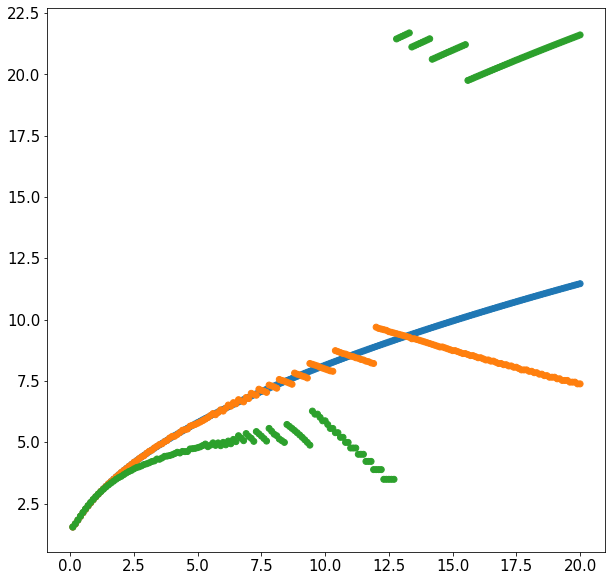

In [56]:
plt.scatter(t['sersic_n'], t['sersic_c2080'], label='Sersic', alpha=t['sersic_r_eff']/t['sersic_r_eff'].max())
plt.scatter(t['sersic_n'], t['corr_c2080'], label='Corrected', alpha=t['sersic_r_eff']/t['sersic_r_eff'].max())
plt.scatter(t['sersic_n'], t['uncorr_c2080'], label='Uncorrected', alpha=t['sersic_r_eff']/t['sersic_r_eff'].max())


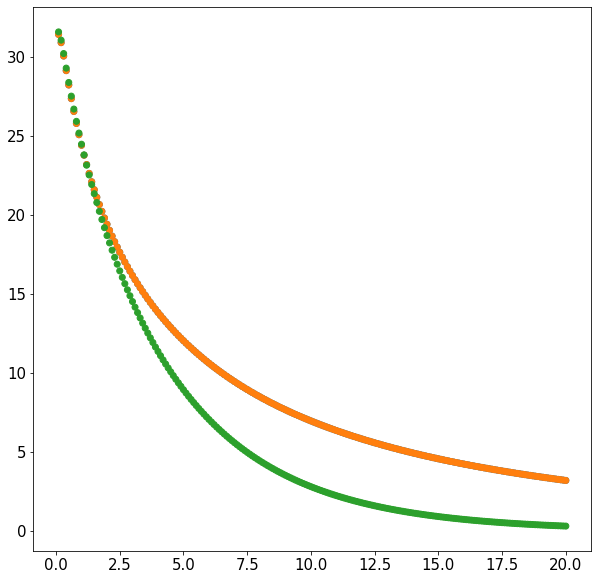

In [241]:
plt.scatter(t['sersic_n'], t['sersic_r_20'], label='Sersic', alpha=t['sersic_r_eff']/t['sersic_r_eff'].max())
plt.scatter(t['sersic_n'], t['corr_r_20'], label='Corrected', alpha=t['sersic_r_eff']/t['sersic_r_eff'].max())
plt.scatter(t['sersic_n'], t['uncorr_r_20'], label='Uncorrected', alpha=t['sersic_r_eff']/t['sersic_r_eff'].max())


In [46]:
from astropy.modeling import custom_model, powerlaws


def c2080_model(n):
    gamma_inv_1 = gammaincinv(2*n, g)

In [79]:
@custom_model
def log10_model(x, amplitude=1, tau=1):
    return amplitude * np.log10(x * tau)

@custom_model
def exp10(x, amplitude=1, tau=1):
    return amplitude * 10**(x * tau)

In [ ]:
models.pow

('amplitude', 'x_break', 'alpha_1', 'alpha_2', 'delta')
[ 5.36768281  4.87564705 -3.06580059 -5.34133834  0.03769015]
range_c2080 = (2.79, 5.96)


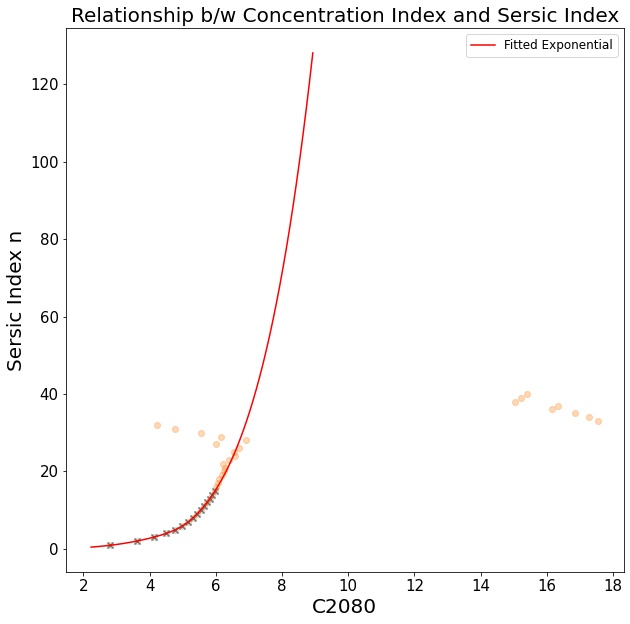

In [127]:

# import numpy as np 
# from petrofit.petrosian import PetrosianCorrection
# from astropy.modeling import models, fitting

# %matplotlib inline

# from matplotlib import pyplot as plt
# plt.rcParams['figure.figsize'] = [10, 10]
# plt.rcParams['image.origin'] = 'lower'



pc = PetrosianCorrection("concentration_index_grid_no_psf.yaml")

keyx = 'c_index'
keyy = 'n'

x = []
y = []

# x = t[np.where(t['uncorr_c2080'] < 40.5)]['sersic_n']
# y = t[np.where(t['uncorr_c2080'] < 40.5)]['corr_epsilon']

x = list(t[np.where(t['sersic_n'] < 16)]['uncorr_c2080']) 
y = list(t[np.where(t['sersic_n'] < 16)]['sersic_n'])

# for i, key in enumerate(list(pc.grid.keys())[:]):
#     if key < 10 or key > 90:
#         continue
#     a = (i+2) / len(pc.grid)
#     data = pc.grid[key]
#     plt.scatter(data[keyx], np.array(data[keyy]), c='black', alpha=a, label='r_eff={}'.format(key))

#     x += data[keyx]
#     y += data[keyy]

x = np.array(x)
y = np.array(y)

plt.scatter(x, y, marker='x')
#plt.plot(data[keyx], 10.0**(-1.7) * np.array(data[keyx])**3.5)

# initialize a linear fitter
fit = fitting.LevMarLSQFitter()
#fit = fitting.LinearLSQFitter()
# initialize a linear model
exp1d = models.Exponential1D()
#line_init = models.Exponential1D() + models.Const1D()

poly = models.Polynomial1D(4) #*line_init
power = powerlaws.SmoothlyBrokenPowerLaw1D()
#line_init = models.Polynomial1D(5)
line_init = power

#fitted_line = fit(line_init, x, y)

print(fitted_line.param_names)
print(fitted_line.parameters)

arr = np.arange(min(x)*0.8, max(x)*1.5, 0.1)

plt.plot(arr, fitted_line(arr), c='red', label='Fitted Exponential'.format(*fitted_line.parameters))
#plt.plot(arr, 0.1102*np.exp(arr/1.25))

plt.title("Relationship b/w Concentration Index and Sersic Index")
plt.xlabel("C2080")
plt.ylabel("Sersic Index n")
plt.legend()

savefig("concentration_index_vs_n.png")

print("range_c2080 = ({:.2f}, {:.2f})".format(x.min(), x.max()))

#plt.scatter(t['corr_c2080'], t['sersic_n'])
plt.scatter(t['uncorr_c2080'], t['sersic_n'], alpha=0.3)
#plt.scatter(t['uncorr_c2080'], t['corr_c2080'], alpha=0.3)


#plt.scatter(py2, (0.12255 * np.exp(np.array(py2)/1.29494)) - 0.04285)

In [22]:
fitted_line(arr)

array([ 0.3836068 ,  0.41246061,  0.44348471,  0.47684236,  0.51270908,
        0.55127359,  0.5927388 ,  0.63732292,  0.68526052,  0.73680386,
        0.79222413,  0.85181296,  0.91588389,  0.98477405,  1.05884593,
        1.13848929,  1.22412319,  1.31619823,  1.41519889,  1.5216461 ,
        1.63609996,  1.75916271,  1.89148188,  2.03375373,  2.18672686,
        2.35120619,  2.52805718,  2.7182104 ,  2.92266639,  3.14250099,
        3.3788709 ,  3.63301989,  3.90628524,  4.20010482,  4.51602467,
        4.8557071 ,  5.22093948,  5.61364359,  6.03588577,  6.4898878 ,
        6.97803857,  7.50290663,  8.06725377,  8.67404948,  9.32648663,
       10.02799823, 10.78227552, 11.59328739, 12.46530124, 13.40290548,
       14.41103363, 15.49499028, 16.66047905, 17.91363255, 19.26104466,
       20.70980524])

In [68]:
poly.fixed

{'c0': False, 'c1': False}

In [21]:
np.max(t[np.where(t['uncorr_c2080'] < 4.5)]['uncorr_c2080'])

4.434802433457039

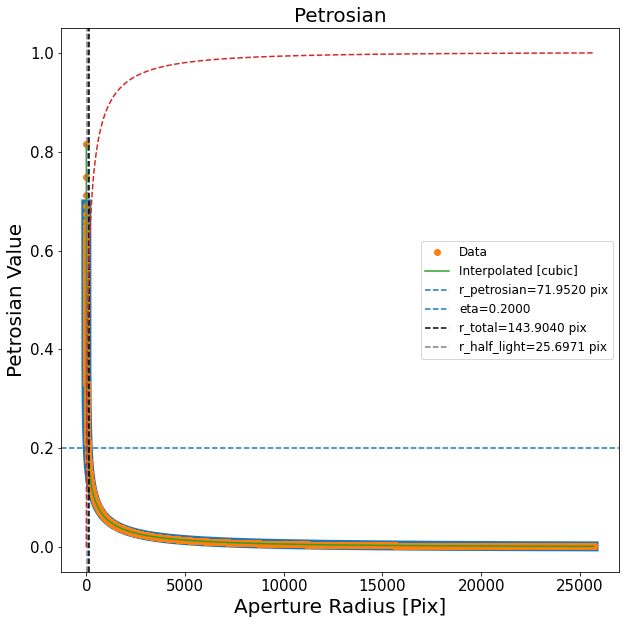

In [70]:
plt.plot(r_list, pp, linewidth=10)
p.plot(1,1)


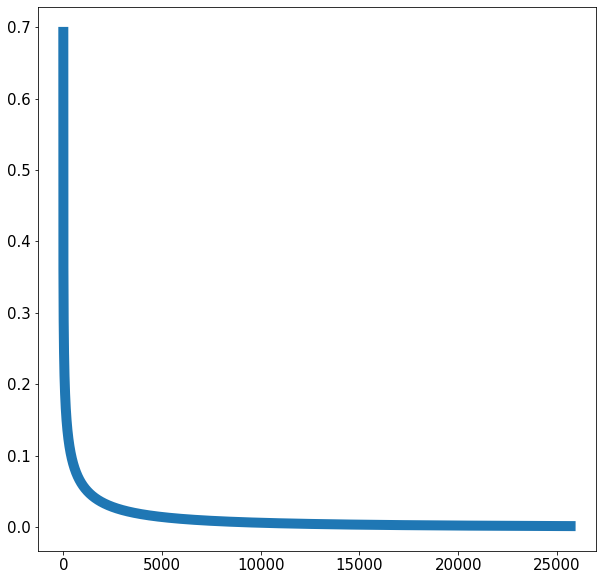

In [124]:
run = True 

delta = 20
r_eff_list = [50]#np.arange(delta, 100 + delta, delta)
delta = 1
n_list = np.arange(delta, 40 + delta, delta)

rows = []
if run:
    with ProgressBar(len(r_eff_list) * len(n_list), ipython_widget=True) as bar:
        for n_idx, n in enumerate(n_list):

            for r_eff_idx, r_eff in enumerate(r_eff_list):
                bar.update()

                b_n = gammaincinv(2. * n, 0.5)
                amplitude=1 #/np.exp(b_n)

                total_flux = sersic_enclosed(np.inf, amplitude, r_eff, n)
                enclosed_99 = total_flux*.99

                r_99 = sersic_enclosed_inv(enclosed_99, amplitude, r_eff, n)
                r_20 = sersic_enclosed_inv(enclosed_99*0.2, amplitude, r_eff, n)
                r_80 = sersic_enclosed_inv(enclosed_99*0.8, amplitude, r_eff, n)
                r_90 = sersic_enclosed_inv(enclosed_99*0.9, amplitude, r_eff, n)
                r_50 = sersic_enclosed_inv(enclosed_99*0.5, amplitude, r_eff, n)

                oversample = 10000
                max_pix=int(r_80)*oversample

                r_list = make_radius_list(
                            max_pix=max_pix, # Max pixel to go up to
                            n=max_pix,# the number of radii to produce
                )
                r_list /=oversample
                
                delta = ((2*r_99)-r_80)
                if delta > 1000:
                    delta /= 1000
                else:
                    delta = 1
                    
                r_list = list(r_list) + list(np.arange(r_80+delta, (2*r_99)+delta, delta))
                r_list = np.array(r_list)

                flux_arr = sersic_enclosed(r_list, amplitude, r_eff, n)
                area_arr = np.pi*(r_list**2)
                
                petrosian_list = petrosian_profile(r_list, r_eff, n)
                
                # Interpolate values
                
                eta = 0.2 
                idx = closest_value_index(eta, petrosian_list)
                r_petrosian = r_list[idx]
                
                idx_list = np.where(petrosian_list <= eta)[0]

                #print(total_flux)
                epsilon = r_99 / r_petrosian
                p_corr = None#Petrosian(r_list, area_arr, flux_arr, epsilon=epsilon)
      
                p_corr_eta = eta
                p_corr_epsilon = epsilon
                p_corr_r_petrosian = r_petrosian
                p_corr_r_total_flux = r_petrosian * p_corr_epsilon
                f = interp1d(r_list, flux_arr, kind='linear')
                p_corr_total_flux = f(p_corr_r_total_flux)
                p_corr_r_20 = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.2)
                p_corr_r_80 = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.8)
                p_corr_r_half_light = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.5)
                
                                
                p_uncorr_eta = eta
                p_uncorr_epsilon = 2
                p_uncorr_r_petrosian = r_petrosian
                p_uncorr_r_total_flux = r_petrosian * p_uncorr_epsilon
                f = interp1d(r_list, flux_arr, kind='linear')
                p_uncorr_total_flux = f(p_uncorr_r_total_flux)
                p_uncorr_r_20 = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.2)
                p_uncorr_r_80 = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.8)
                p_uncorr_r_half_light = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.5)
                

                rows.append([
                    n, r_eff, amplitude, total_flux, r_99, r_20, r_80, 5 *np.log10(r_80 / r_20),
                    p_corr_eta, p_corr_epsilon, p_corr_r_petrosian, p_corr_r_half_light, p_corr_r_total_flux, p_corr_total_flux, p_corr_r_20, p_corr_r_80, 5 *np.log10(p_corr_r_80 / p_corr_r_20), 
                    p_uncorr_eta, p_uncorr_epsilon, p_uncorr_r_petrosian, p_uncorr_r_half_light, p_uncorr_r_total_flux, p_uncorr_total_flux, p_uncorr_r_20, p_uncorr_r_80, 5 *np.log10(p_uncorr_r_80 / p_uncorr_r_20),
                ])



                assert not np.any(np.isnan(np.array(rows[-1]))), "{}".format(n)
                #plt.plot(r_list, petrosian_list)
                #plt.show()
                break 

    names = [
        "sersic_n", "sersic_r_eff", "sersic_amplitude", "sersic_total_flux_99", "sersic_r_99", "sersic_r_20", "sersic_r_80", "sersic_c2080",
        "corr_eta", "corr_epsilon", "corr_r_petrosian", "corr_r_half_light", "corr_r_total_flux", "corr_total_flux", "corr_r_20", "corr_r_80", "corr_c2080",
        'uncorr_eta', 'uncorr_epsilon', 'uncorr_r_petrosian', 'uncorr_r_half_light', 'uncorr_r_total_flux', 'uncorr_total_flux', 'uncorr_r_20', 'uncorr_r_80', 'uncorr_c2080'
    ]

    t = Table(rows=rows, names=names)

    plt.show()
    print("done")
else:
    t = Table.read('pure_grid.csv')


FloatProgress(value=0.0)


done


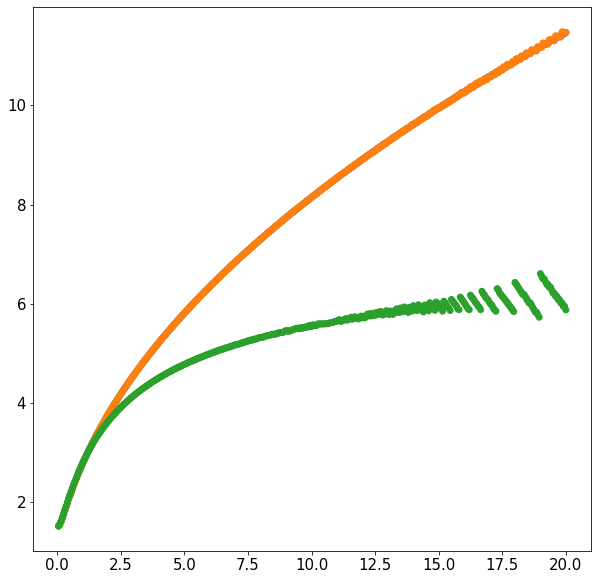

In [44]:
plt.scatter(t['sersic_n'], t['sersic_c2080'], label='Sersic', alpha=t['sersic_r_eff']/t['sersic_r_eff'].max())
plt.scatter(t['sersic_n'], t['corr_c2080'], label='Corrected', alpha=t['sersic_r_eff']/t['sersic_r_eff'].max())
plt.scatter(t['sersic_n'], t['uncorr_c2080'], label='Uncorrected', alpha=t['sersic_r_eff']/t['sersic_r_eff'].max())


In [20]:

def fraction_flux_to_r(r_list, flux_list, r_total_flux, fraction=0.5):
    """
    Given photometric values and `r_total_flux`, calculate radius which encloses a specified
    fraction of the total flux.

    Parameters
    ----------
    r_list : numpy.array
        Array of radii in pixels.

    flux_list : numpy.array
        Array of photometric flux values.

    r_total_flux : float
        Total flux radius (hint: `petrofit.petrosian.calculate_r_total_flux` can be used to measure this).

    fraction : float
        Fraction of flux total flux enclosed in target radius.

    Returns
    -------
    r_fraction_flux : float or numpy.nan
        Radius which encloses a specified fraction of the total flux (determined by the Petrosian profile).
    """

    if r_total_flux > max(r_list):
        return np.nan

    f = interp1d(r_list, flux_list, kind='nearest')
    total_flux = f(r_total_flux)
    fractional_flux = total_flux * fraction

    r_list_new, flux_list_new = r_list, flux_list#get_interpolated_values(r_list, flux_list, num=len(r_list)*4, kind='cubic' )

    #idx = abs(flux_list_new - fractional_flux).argmin()
    idx = closest_value_index(fractional_flux, flux_list_new, growing=True)
    return np.nan if idx is None else r_list_new[idx]

In [12]:

def fraction_flux_to_r(r_list, flux_list, total_flux, fraction=0.5):
    """
    Given photometric values and `r_total_flux`, calculate radius which encloses a specified
    fraction of the total flux.

    Parameters
    ----------
    r_list : numpy.array
        Array of radii in pixels.

    flux_list : numpy.array
        Array of photometric flux values.

    r_total_flux : float
        Total flux radius (hint: `petrofit.petrosian.calculate_r_total_flux` can be used to measure this).

    fraction : float
        Fraction of flux total flux enclosed in target radius.

    Returns
    -------
    r_fraction_flux : float or numpy.nan
        Radius which encloses a specified fraction of the total flux (determined by the Petrosian profile).
    """

    fractional_flux = total_flux * fraction

    r_list_new, flux_list_new = r_list, flux_list

    # idx = abs(flux_list_new - fractional_flux).argmin()
    idx = closest_value_index(fractional_flux, flux_list_new, growing=True)
    return np.nan if idx is None else r_list_new[idx]

In [218]:
f = interp1d(r_list, flux_larr, kind='nearest')

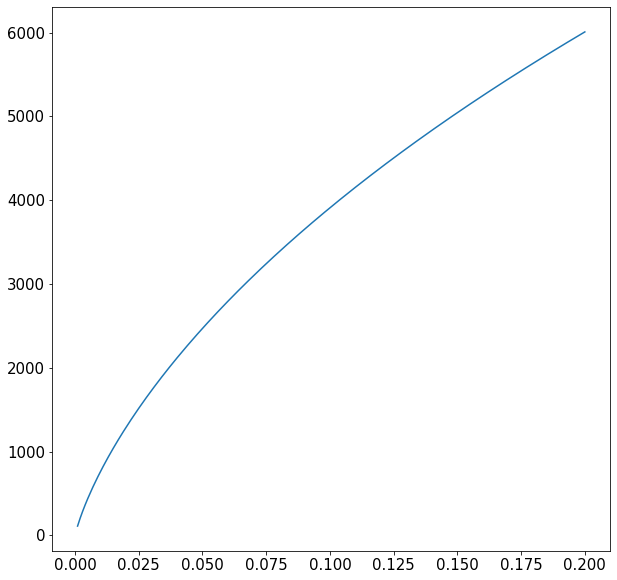

In [219]:
plt.plot(r_list[:200], f(r_list[:200]))

In [ ]:

def discrete_petrosian_r(r_list, area_list, flux_list, eta=0.2):
    """
    Calculate petrosian radius from photometric values by using the nearest value petrosian to eta.
    The petrosian radius is defined as the radius at which the petrosian profile equals eta.

    Parameters
    ----------
    r_list : numpy.array
        Array of radii in pixels.

    area_list : numpy.array
        Array of aperture areas.

    flux_list : numpy.array
        Array of photometric flux values.

    eta : float, default=0.2
        Eta is the petrosian value which defines the `r_petrosian`.

    Returns
    -------
    r_petrosian : float or numpy.nan
        Petrosian radius
    """

    petrosian_list = calculate_petrosian(area_list, flux_list)
    

    r_petrosian = np.nan
    if idx_list.size > 0:
        idx = idx_list[0]
        r_petrosian = r_list[idx]

    return r_petrosian


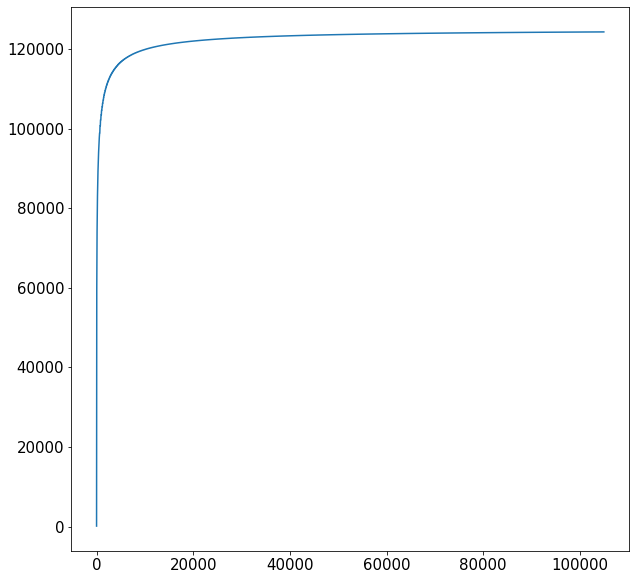

In [67]:
x, y = get_interpolated_values(r_list, flux_arr, kind='nearest')
plt.plot(x, y)

In [123]:
ot = t